In [1366]:
%%bash
#Split the all_views, get one file(sentiment, tweet) for each view
#Clean each view
#Run this for each view.
norm() {
    fn=$1
    if [ ! -f "$fn" ]
    then
        echo "File: $fn not found"
        return 0
    fi
    #this function will convert text to lowercase and will disconnect punctuation and special symbols from words
    function normalize_text {
        awk '{print tolower($0);}' < $1 | sed -e 's/\./ \. /g' -e 's/<br \/>/ /g' -e 's/"/ " /g' \
        -e 's/,/ , /g' -e 's/(/ ( /g' -e 's/)/ ) /g' -e 's/\!/ \! /g' -e 's/\?/ \? /g' \
        -e 's/\;/ \; /g' -e 's/\:/ \: /g' > $1-norm
    }
    export LC_ALL=C
    normalize_text "$fn"
    wc -l $fn
    mv "$fn" "$fn-norm"
}
norm "data/view1_clean" #file name is
norm "data/view2_clean"
norm "data/test_clean"

File: data/view1_clean not found
File: data/view2_clean not found
File: data/test_clean not found


In [1367]:
import os.path
tw_view_1 = 'data/view1_clean-norm'
tw_view_2 = 'data/view2_clean-norm'
tw_test = 'data/test_clean-norm'
assert os.path.isfile(tw_view_1), tw_view_1 + " unavailable"
assert os.path.isfile(tw_view_2), tw_view_2 + " unavailable"
assert os.path.isfile(tw_test), tw_test + " unavailable"

In [1368]:
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stem_document(doc_sentence):
    words = doc_sentence.split()
    stemmed = ' '.join([stemmer.stem(word) for word in words])
    return stemmed

In [1428]:
import gensim
import numpy as np
#from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple, defaultdict as dd

#sentiment = {'positive':1, 'negative':-1} #, 'neutral':2}
sentiment_dict = {'4':1, '0':-1} #- new data 0,4
SentimentDocument = namedtuple('SentimentDocument', 'words tags split sentiment')
stem = True

alldocs = dd(list)  # will hold all docs in original order - dictionary, keys = [v1, v2]
v1 = 'view1'
v2 = 'view2'
#tw_sentiment_dict = {}
#print total_num, train_test_shuffle
all_v2_words = []
with open(tw_view_2) as allview2:
        all_v2_words = allview2.readlines()
total_num = len(all_v2_words)
#split train/test
train_num = total_num *  8 / 10 # 70% train/test 1 - 10
train_test_shuffle = np.arange(total_num)
np.random.shuffle(train_test_shuffle)
with open(tw_view_1) as allview1:
    #for line_no, (v1, v2) in enumerate(zip(allview1, allview2)):
    for line_no, line in enumerate(allview1):
        tokens = gensim.utils.to_unicode(line).split('\t')
        if len(tokens) != 2:
            print line
            raise Exception()
        sentiment = sentiment_dict[tokens[0]]
        #if tw_id not in tw_sentiment_dict.keys():
        #    continue
        words = tokens[1]
        split = 'train' if train_test_shuffle[line_no] <= train_num else 'dev'
        #sentiment = tw_sentiment_dict[tw_id]
        v2_words = gensim.utils.to_unicode(all_v2_words[line_no]).split('\t')[1]
        
        alldocs[v1].append(SentimentDocument(stem_document(words) if stem else words, [line_no], split, sentiment))
        alldocs[v2].append(SentimentDocument(stem_document(v2_words) if stem else v2_words, [line_no], split, sentiment))
# test file
with open(tw_test) as test_fh:
    for line_no, line in enumerate(test_fh):
        tokens = gensim.utils.to_unicode(line).split('\t')
        if len(tokens) != 2:
            print line
            raise Exception()
        sentiment = sentiment_dict[tokens[0]]
        #if tw_id not in tw_sentiment_dict.keys():
        #    continue
        words = tokens[1]
        split = 'test'
        
        alldocs[v1].append(SentimentDocument(stem_document(words) if stem else words, \
                                             [total_num+line_no], split, sentiment))
train_docs = {
    v1 : [doc for doc in alldocs[v1] if doc.split == 'train'],
    v2 : [doc for doc in alldocs[v2] if doc.split == 'train']
}
dev_docs = {
    v1 : [doc for doc in alldocs[v1] if doc.split == 'dev'],
    v2 : [doc for doc in alldocs[v2] if doc.split == 'dev']
}
test_docs = {
    v1 : [doc for doc in alldocs[v1] if doc.split == 'test'],
    v2 : [doc for doc in alldocs[v2] if doc.split == 'test']
}
doc_list = { v1: alldocs[v1][:], v2: alldocs[v2][:] }  # for reshuffling per pass

print('%d docss: %d train, %d dev, %d test' % (len(doc_list[v1]), len(train_docs[v1]), len(dev_docs[v1]), len(test_docs[v1])))

4164 docss: 3045 train, 760 dev, 359 test


In [1465]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"
model_size = 500
simple_models , models_by_name = {}, {} 
for view in [v1, v2]:
    simple_models[view] = [
        # PV-DM w/concatenation - window=5 (both sides) approximates paper's 10-word total window size
        Doc2Vec(dm=1, dm_concat=1, size=model_size, window=3, negative=5, hs=0, min_count=2, workers=cores),
        # PV-DBOW 
        Doc2Vec(dm=0, size=model_size, negative=5, hs=0, min_count=5, workers=cores),
        # PV-DM w/average
        Doc2Vec(dm=1, dm_mean=1, size=model_size, window=3, negative=5, hs=0, min_count=2, workers=cores),
    ]

    # speed setup by sharing results of 1st model's vocabulary scan
    simple_models[view][0].build_vocab(alldocs[view])  # PV-DM/concat requires one special NULL word so it serves as template
    print view, simple_models[view][0]
    for model in simple_models[view][1:]:
        model.reset_from(simple_models[view][0])
        print view, model

    models_by_name[view] = OrderedDict((str(model), model) for model in simple_models[view])

view1 Doc2Vec(dm/c,d500,n5,w3,mc2,t4)
view1 Doc2Vec(dbow,d500,n5,mc5,t4)
view1 Doc2Vec(dm/m,d500,n5,w3,mc2,t4)
view2 Doc2Vec(dm/c,d500,n5,w3,mc2,t4)
view2 Doc2Vec(dbow,d500,n5,mc5,t4)
view2 Doc2Vec(dm/m,d500,n5,w3,mc2,t4)


In [1466]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
for view in [v1, v2]:
    models_by_name[view]['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[view][1], simple_models[view][2]])
    models_by_name[view]['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[view][1], simple_models[view][0]])
#print models_by_name['dbow+dmm'], models_by_name['dbow+dmc'] 
#del models_by_name['dbow+dmc']

In [1467]:
import numpy as np
import statsmodels.api as sm
from sklearn import svm, metrics, neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from random import sample

# for timing
from contextlib import contextmanager
from timeit import default_timer
import time 
import ipdb

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start
    
def logistic_predictor(train_targets, train_regressors):
    lr = LogisticRegression()
    lr.fit(train_regressors, train_targets)
    return lr

def svm_predictor(train_targets, train_regressors):
    svc = svm.SVC(kernel='rbf', degree=5, gamma=1e-1)
    svc.fit(train_regressors, train_targets)
    return svc

    """expected = svm_y_test
    predicted = svc.predict(svm_x_test)

    #print("Classification report for classifier %s:\n%s\n"
    #      % (svc, metrics.classification_report(expected, predicted)))
    #print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))
    """
def rf_predictor(train_targets, train_regressors):
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(train_regressors, train_targets)
    return rfc

def error_rate_for_model(test_model, train_set, test_set, infer=False, infer_steps=3, infer_alpha=0.1, infer_subsample=0.1):
    """Report error rate on test_doc sentiments, using supplied model and train_docs"""

    train_targets, train_regressors = zip(*[(doc.sentiment, test_model.docvecs[doc.tags[0]]) for doc in train_set])
    predictor = predictor_alg(train_targets, train_regressors)

    test_data = test_set
    if infer:
        if infer_subsample < 1.0:
            test_data = sample(test_data, int(infer_subsample * len(test_data)))
        test_regressors = [test_model.infer_vector(doc.words, steps=infer_steps, alpha=infer_alpha) for doc in test_data]
    else:
        test_regressors = [test_model.docvecs[doc.tags[0]] for doc in test_data]
    
    # predict & evaluate
    test_predictions = predictor.predict(test_regressors)
    predicted = np.rint(test_predictions)
    expected = [doc.sentiment for doc in test_data]
    """if not infer:
        print("Classification report for classifier %s:\n%s\n"
              % (predictor, metrics.classification_report(expected, predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))"""
    #ipdb.set_trace()
    corrects = sum(expected == predicted)
    errors = len(test_predictions) - corrects
    error_rate = float(errors) / len(test_predictions)
    return (error_rate, errors, len(test_predictions), predictor)

In [1468]:
from matplotlib import pyplot as plt
from scipy.linalg import eigh
%matplotlib inline
def center(data):
    return data - np.mean(data, axis=0)

def PLS(X, Y):
    cross_cov = np.dot(center(X), center(Y).T)
    eigval,eigvec=np.linalg.eig(cross_cov.dot(cross_cov.T))
    return (eigval, eigvec)

def PLS_MFCC():
    dims = [10, 30, 50, 70, 90, 110]
    accuracies = np.zeros((len(num_neighb), len(dims)))
    # (score, dim, k, PLS_subspace, classifier_object)
    best = (0, 0, 0, None, None)
    #run pls
    eigval, U = PLS(acoustic_train, artic_train)
    for j, k in enumerate(num_neighb):
        for i, d in enumerate(dims):
            U_d = get_top_eigvec(eigval, U, d)
            #get projection to pls space
            train_proj = np.dot(U_d.T, acoustic_train_cen)
            dev_proj = np.dot(U_d.T, acoustic_dev_cen)
            # stack with mfcc39
            stacked_train = np.append(train_proj, mfcc39_train, axis=0)
            stacked_dev = np.append(dev_proj, mfcc39_dev, axis=0)

            #classify
            clf = neighbors.KNeighborsClassifier(k)
            clf.fit(stacked_train.T, phones_train)

            #predictions
            score = clf.score(stacked_dev.T, phones_dev)
            if score > best[0]:
                best = (score, d, k, U_d, clf)
            accuracies[j,i] = score
    return (best, accuracies)

def kcca(X, Y, regX=0.1, regY=0.1, numCC=10, kernelcca=True, ktype="gaussian"):
    '''Set up and solve the eigenproblem for the data in kernel and specified reg
    '''
    cenX = center(X)
    cenY = center(Y)
    kernel1 = np.array([_make_kernel(X.T, ktype=ktype)])
    kernel_x = (kernel1 + kernel1.T)/2
    kernel2 = np.array([_make_kernel(Y.T, ktype=ktype)])
    kernel_y = (kernel2 + kernel2.T)/2
    r_Ix = regX * np.eye(kernel_x.shape[0])
    r_Iy = regY * np.eye(kernel_y.shape[0])
    A = reduce(np.dot, [ np.linalg.inv(kernel_x - r_Ix), kernel_y, np.linalg.inv(kernel_y - r_Iy), kernel_x])
    eigval,eigvec=np.linalg.eig(A)
    return (eigval, eigvec)

def _listcorr(a):
    '''Returns pairwise row correlations for all items in array as a list of matrices
    '''
    corrs = np.zeros((a[0].shape[1], len(a), len(a)))
    for i in range(len(a)):
        for j in range(len(a)):
            if j > i:
                corrs[:, i, j] = [np.nan_to_num(np.corrcoef(ai, aj)[0, 1]) for (ai, aj) in zip(a[i].T, a[j].T)]
    return corrs


def recon(data, comp, corronly=False, kernelcca=True):
    nT = data[0].shape[0]
    # Get canonical variates and CCs
    if kernelcca:
        ws = _listdot(data, comp)
    else:
        ws = comp
    ccomp = _listdot([d.T for d in data], ws)
    corrs = _listcorr(ccomp)
    if corronly:
        return corrs
    else:
        return corrs, ws, ccomp


def _listdot(d1, d2): return [np.dot(x[0].T, x[1]) for x in zip(d1, d2)]


def _make_kernel(d, normalize=True, ktype="linear", sigma=1.0):
    '''Makes a kernel for data d
      If ktype is "linear", the kernel is a linear inner product
      If ktype is "gaussian", the kernel is a Gaussian kernel with sigma = sigma
    '''
    if ktype == "linear":
        d = np.nan_to_num(d)
        cd = _demean(d)
        kernel = np.dot(cd, cd.T)
    elif ktype == "gaussian":
        from scipy.spatial.distance import pdist, squareform
        # this is an NxD matrix, where N is number of items and D its dimensionalites
        pairwise_dists = squareform(pdist(d, 'euclidean'))
        kernel = np.exp(-pairwise_dists ** 2 / sigma ** 2)
    kernel = (kernel + kernel.T) / 2.
    kernel = kernel / np.linalg.eigvalsh(kernel).max()
    return kernel


def _demean(d): return d - d.mean(0)

def CCA(X, Y, regX = 0, regY = 0):
    cenX = center(X)
    cenY = center(Y)
    cross_cov = cenX.dot(cenY.T)
    covX = cenX.dot(cenX.T)
    covY = cenY.dot(cenY.T)
    r_Ix = regX * np.eye(covX.shape[0])
    r_Iy = regY * np.eye(covY.shape[0])
    A = reduce(np.dot, [ np.linalg.inv(covX + r_Ix), cross_cov, np.linalg.inv(covY + r_Iy), cross_cov.T ])
    eigval,eigvec=np.linalg.eig(A)
    return (eigval, eigvec)

def get_top_eigvec(eigval, eigvec, k):
    idx=np.argsort(eigval)[-k:][::-1]
    #eigval=eigval[idx]
    return eigvec[:,idx]

def CCA_MFCC():
    dims = [10, 30, 50, 70, 90, 110]
    reg = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1e1]
    accuracies = np.zeros((len(reg), len(reg), len(dims), len(num_neighb)))
    # (score, dim, regX, regY, k, CCA_subspace, classifier_object)
    best = (0, 0, 0, 0, 0, None, None)
    for rx, regX in enumerate(reg):
        for ry, regY in enumerate(reg):
            #run cca
            eigval, U = CCA(acoustic_train, artic_train, regX, regY)
            for i, d in enumerate(dims):
                U_d = get_top_eigvec(eigval, U, d)
                #get projection to cca space
                train_proj = U_d.T.dot(acoustic_train_cen)
                dev_proj = U_d.T.dot(acoustic_dev_cen)
                # stack with mfcc39
                stacked_train = np.append(train_proj, mfcc39_train, axis=0)
                stacked_dev = np.append(dev_proj, mfcc39_dev, axis=0)
                #classify
                for j, k in enumerate(num_neighb):
                    clf = neighbors.KNeighborsClassifier(k)
                    clf.fit(stacked_train.T, phones_train)

                    #predictions
                    score = clf.score(stacked_dev.T, phones_dev)
                    if score > best[0]:
                        best = (score, d, regX, regY, k, U_d, clf)
                    accuracies[rx, ry, i, j] = score
    return (best, accuracies)

def plot_pc2(data, eigvec, phones_data):
    #project to top 2 princ. comp.
    data_proj = np.dot(np.transpose(eigvec), data)
    data_proj_labels=[data_proj[:,np.where(phones_data==lbl)] for lbl in labels_dict.values()]
    #Plot
    cmap = plt.get_cmap('jet_r')
    N=len(labels)
    colors = [cmap(float(i)/N) for i in np.linspace(5.0, 0, N)]
    plt.figure(figsize=(7,7))
    #plt.subplot(2,1,1)
    for i in range(N):
        plt.scatter(data_proj_labels[i][0,:], data_proj_labels[i][1,:] ,c=colors[i], marker='+', label=labels[i]);
    #plt.legend(plots,labels)
    plt.legend(loc=3)
    #plt.show()
    return plt

In [1469]:
#from collections import defaultdict
best_error = dd(lambda: dd(lambda :(1.0, 0.0))) # { view: { model_name : (error_rate, alpha) } } ,to selectively-print only best errors achieved

In [1470]:
#predictor_alg = logistic_predictor
predictor_alg = logistic_predictor
from random import shuffle
import datetime

print 'Started.'
for view in [v1, v2]:
    alpha, min_alpha, passes = (0.025, 0.001, 10)
    alpha_delta = (alpha - min_alpha) / passes

    print "======== %s =========" %view
    print("START %s" % datetime.datetime.now())

    for epoch in range(passes):
        shuffle(doc_list[view])  # shuffling gets best results

        for name, train_model in models_by_name[view].items():
            #print name
            # train
            duration = 'na'
            train_model.alpha, train_model.min_alpha = alpha, alpha
            with elapsed_timer() as elapsed:
                train_model.train(doc_list[view])
                duration = '%.1f' % elapsed()

            # evaluate
            eval_duration = ''
            with elapsed_timer() as eval_elapsed:
                err, err_count, test_count, predictor = error_rate_for_model(train_model, train_docs[view], dev_docs[view])
            eval_duration = '%.1f' % eval_elapsed()
            best_indicator = ' '
            if err < best_error[view][name][0]:
                best_error[view][name] = (err, alpha)
                best_indicator = '*' 
            #print("%s%f : %i passes : %s-%s %ss %ss" % (best_indicator, err, epoch + 1, view, name, duration, eval_duration))

            """if ((epoch + 1) % 5) == 0 or epoch == 0:
                eval_duration = ''
                with elapsed_timer() as eval_elapsed:
                    infer_err, err_count, test_count, predictor = error_rate_for_model(train_model, train_docs[view], test_docs[view], infer=True)
                eval_duration = '%.1f' % eval_elapsed()
                best_indicator = ' '
                if infer_err < best_error[view][name + '_inferred'][0]:
                    best_error[view][name + '_inferred'] = (infer_err, alpha)
                    best_indicator = '*'
                print("%s%f : %i passes : %s-%s %ss %ss" % (best_indicator, infer_err, epoch + 1, view, name + '_inferred', duration, eval_duration))
"""
        #print('completed pass %i at alpha %f' % (epoch + 1, alpha))
        alpha -= alpha_delta

    print("END %s" % str(datetime.datetime.now()))

Started.
======== view1 =========
START 2015-12-15 09:47:51.845102
END 2015-12-15 09:48:32.341065
======== view2 =========
START 2015-12-15 09:48:32.341488
END 2015-12-15 09:49:09.631326


In [1471]:
for view in [v1, v2]:
    print '========= %s ========' %view
    for rate, alpha, name in sorted((rate, alpha, name) for name, (rate, alpha) in best_error[view].items()):
        print("%f %s %f" % (rate, name, alpha))

========= view1 ========
0.400000 dbow+dmc 0.013000
0.411842 Doc2Vec(dm/c,d500,n5,w3,mc2,t4) 0.013000
0.413158 dbow+dmm 0.008200
0.422368 Doc2Vec(dbow,d500,n5,mc5,t4) 0.013000
0.432895 Doc2Vec(dm/m,d500,n5,w3,mc2,t4) 0.008200
========= view2 ========
0.414474 dbow+dmc 0.017800
0.428947 Doc2Vec(dm/c,d500,n5,w3,mc2,t4) 0.017800
0.428947 Doc2Vec(dbow,d500,n5,mc5,t4) 0.020200
0.443421 Doc2Vec(dm/m,d500,n5,w3,mc2,t4) 0.025000
0.450000 dbow+dmm 0.017800


In [1472]:
doc_id = np.random.randint(simple_models[v2][0].docvecs.count)  # pick random doc; re-run cell for more examples
print('for doc %d...' % doc_id)
# Print example tweet and vector reps for both views
print alldocs['view1'][doc_id]
#tag = alldocs['view1'][doc_id].tags[0]
#print '\n', simple_models['view1'][0].docvecs[tag]

print '\n', alldocs['view2'][doc_id]
#print '\n', simple_models['view2'][0].docvecs[tag]
#print '\n\n', doc_list['view2'][:10]
for model in simple_models[v1]:
    inferred_docvec = model.infer_vector(alldocs[v1][doc_id].words)
    print('%s:\n %s' % (model, model.docvecs.most_similar([inferred_docvec], topn=3)))

for doc 728...
SentimentDocument(words=u'unpack listen to the clash miss my boy', tags=[728], split='train', sentiment=-1)

SentimentDocument(words=u"i don't know what right and what real anymore. i don't know how i'm meant to feel anymore. i'v been taken over by the fear. . .", tags=[728], split='train', sentiment=-1)
Doc2Vec(dm/c,d500,n5,w3,mc2,t4):
 [(728, 0.7739375233650208), (3248, 0.7707007527351379), (2776, 0.7230231761932373)]
Doc2Vec(dbow,d500,n5,mc5,t4):
 [(728, 0.8397148847579956), (3879, 0.7515110969543457), (422, 0.7322298884391785)]
Doc2Vec(dm/m,d500,n5,w3,mc2,t4):
 [(728, 0.7690732479095459), (3606, 0.6917961239814758), (1610, 0.6907590627670288)]


In [1473]:
#Select the best performing word2vec model
_, best_alpha, best_model_name = min(((rate, alpha, name) \
                                           for name, (rate, alpha) in best_error[v1].items()), key=lambda b: b[0])
print best_model_name 
print best_alpha
best_model = { v1 : models_by_name[v1][best_model_name],
              v2 : models_by_name[v2][best_model_name] }
# Train best model
shuffle(doc_list[view])
for view in [v1, v2]:
    best_model[view].alpha, best_model[view].min_alpha = best_alpha, best_alpha
    best_model[view].train(doc_list[view])

dbow+dmc
0.013


In [1474]:
# DO CCA on the training docvecs
# X = view 1, Y = view 2 : [word_vec_size x num_samples]
target_sentiments, X, Y = zip(*[(doc.sentiment, best_model[v1].docvecs[doc.tags[0]], \
                             best_model[v2].docvecs[doc.tags[0]]) for doc in train_docs[v1]])
X = np.asarray(X).T
Y = np.asarray(Y).T
#dev docs
dev = [best_model[v1].docvecs[doc.tags[0]] for doc in dev_docs[v1]]
dev = np.asarray(dev).T
#test docs
test = [best_model[v1].docvecs[doc.tags[0]] for doc in test_docs[v1]]
test = np.asarray(test).T

In [1488]:
(cca_eigval, cca_eigvec) = CCA(X, Y)  #kcca(X, Y, regX=0.1, regY=0.1, numCC=10, kernelcca=True, ktype="gaussian")
print np.shape(X), np.shape(Y)
print np.shape(cca_eigvec)
#print np.transpose(X)

(1000, 3045) (1000, 3045)
(1000, 1000)


In [1489]:
def error_rate(X, X_targets, test, expected, print_conf=False):
    predictor = predictor_alg(X_targets, X)

    # predict & evaluate
    predictions = predictor.predict(test)
    predicted = np.rint(predictions)
    #print("Classification report for %s:\n%s\n" % (predictor, metrics.classification_report(expected, predicted)))
    if print_conf:
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))
    #ipdb.set_trace()
    errors = len(predictions) - sum(expected == predicted)
    err_orig = float(errors) / len(expected)
    if print_conf:
        print err_orig
    return err_orig*100

In [1490]:
expected = [doc.sentiment for doc in dev_docs[v1]]
err_orig = error_rate(X.T, target_sentiments, dev.T, expected, True)

Confusion matrix:
[[161 176]
 [139 284]]
0.414473684211


In [1491]:
#get top k eigvec, project training data and stack with original word vectors
err_cca = []
step = 50
num_dir_ranges = range(step, step+model_size, step)
for num_dir in num_dir_ranges:
    top_k_eigv = get_top_eigvec(cca_eigval, cca_eigvec, num_dir)
    #print np.shape(top_k_eigv)
    X_proj = top_k_eigv.T.dot(X)
    #print np.shape(X_proj)
    stacked_vec = np.append(X, X_proj, axis=0)
    #print np.shape(stacked_vec)

    # project test data to cca directions and stack
    #print np.shape(test)
    dev_proj = top_k_eigv.T.dot(dev)
    stacked_dev = np.append(dev, dev_proj, axis=0)
    #print np.shape(stacked_dev)
    #print np.shape(target_sentiments)
    
    expected = [doc.sentiment for doc in dev_docs[v1]]
    err_cca.append(error_rate(stacked_vec.T, target_sentiments, stacked_dev.T, expected))

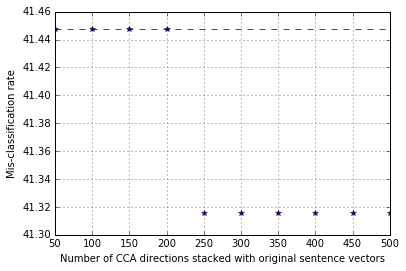

In [1492]:
plt.plot(num_dir_ranges, [err_orig]*len(num_dir_ranges), 'r--', num_dir_ranges, err_cca, 'b*')
plt.ylabel('Mis-classification rate')
plt.xlabel('Number of CCA directions stacked with original sentence vectors')
plt.grid()
plt.show()

In [1493]:
#Test - doc2vec
expected = [doc.sentiment for doc in test_docs[v1]]
error_rate(X.T, target_sentiments, test.T, expected, True)

Confusion matrix:
[[ 71 106]
 [ 47 135]]
0.426183844011


42.618384401114206

In [1494]:
#Test doc2vec stacked with cca
top_k_eigv = get_top_eigvec(cca_eigval, cca_eigvec, 400)
#print np.shape(top_k_eigv)
X_proj = top_k_eigv.T.dot(X)
#print np.shape(X_proj)
stacked_vec = np.append(X, X_proj, axis=0)
#print np.shape(stacked_vec)

# project test data to cca directions and stack
#print np.shape(test)
test_proj = top_k_eigv.T.dot(test)
stacked_test = np.append(test, test_proj, axis=0)
#print np.shape(stacked_test)
#print np.shape(target_sentiments)

expected = [doc.sentiment for doc in test_docs[v1]]
error_rate(stacked_vec.T, target_sentiments, stacked_test.T, expected, True)

Confusion matrix:
[[ 71 106]
 [ 47 135]]
0.426183844011


42.618384401114206

In [1495]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
corpus = [doc.words for doc in alldocs[v1]]
tf_idf = vectorizer.fit_transform(corpus).toarray()

In [1496]:
np.shape(tf_idf)
tf_X = tf_idf[np.array([doc.tags[0] for doc in train_docs[v1]])]
tf_dev = tf_idf[np.array([doc.tags[0] for doc in dev_docs[v1]])]
tf_test = tf_idf[np.array([doc.tags[0] for doc in test_docs[v1]])]

In [1497]:
expected = [doc.sentiment for doc in dev_docs[v1]]
#TF-IDF
err_tf = error_rate(tf_X, target_sentiments, \
           tf_dev, expected, True)
#Tf-IDF stacked with CCA
err_tf_cca = []
step = 50
num_dir_ranges = range(step, step+model_size, step)
for num_dir in num_dir_ranges:
    top_k_eigv = get_top_eigvec(cca_eigval, cca_eigvec, num_dir)
    #print np.shape(top_k_eigv)
    X_proj = top_k_eigv.T.dot(X)
    #print np.shape(X_proj)
    stacked_vec = np.append(X, X_proj, axis=0)
    #print np.shape(stacked_vec)

    # project test data to cca directions and stack
    #print np.shape(test)
    dev_proj = top_k_eigv.T.dot(dev)
    stacked_dev = np.append(dev, dev_proj, axis=0)
    #print np.shape(stacked_dev)
    #print np.shape(target_sentiments)
    err_tf_cca.append(error_rate(np.append(tf_X, X_proj.T, axis=1), target_sentiments, \
               np.append(tf_dev, dev_proj.T, axis=1), expected))

Confusion matrix:
[[197 140]
 [ 92 331]]
0.305263157895


In [1498]:
#TF-IDF stacked with doc2vec
err_tf_doc = error_rate(np.append(tf_X, X.T, axis=1), target_sentiments, \
               np.append(tf_dev, dev.T, axis=1), expected, True)

Confusion matrix:
[[205 132]
 [107 316]]
0.314473684211


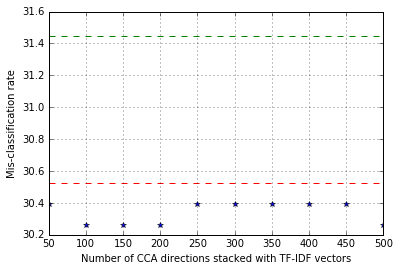

In [1499]:
plt.plot(num_dir_ranges, [err_tf]*len(num_dir_ranges), 'r--', num_dir_ranges, \
         [err_tf_doc]*len(num_dir_ranges), 'g--', num_dir_ranges, err_tf_cca, 'b*')
plt.ylabel('Mis-classification rate')
plt.xlabel('Number of CCA directions stacked with TF-IDF vectors')
plt.grid()
plt.show()

In [1500]:
# Doc2Vec generally does better With Stemming, and gives the best accuracy on test when stacked with tf-idf
# Stacking tf-idf with cca usually does marginally worse, but seemingly better than tf-idf+doc2vec when not stemmed